## What are Ensemble Methods?

This notebook is all about Ensemble Methods: what they are, how they're used, and basic examples of each type. 

>"Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to __decrease variance__ (bagging), __decrease bias__ (boosting), or __improve predictions__ (stacking)." - Vadim Smolyakov

Ensemble methods generally fall into one of two categories: Sequential or Parallel. Sequential models are built one after another, relying on the previous model to influence the next model. You can exploit the dependence between base learners to boost performance by weighting previously mislabeled observations more heavily than previously correctly labeled observations. Parallel models are built separately without any interaction between each other. The goal here is to exploit the independence between the base estimators to reduce error by averaging the predictions.



In [8]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)
%matplotlib inline

### Bagging (Bootstrap Aggregation)
A quick aside to talk about bootstrap sampling. Bootstrapping is the process by which we can take one dataset and create multiple different datasets to use when training our models. In order to do this we pick out a number of observations at random (with replacement) from our original dataset. The result is multiple subsets of the original data with each having the potential for missing or duplicated observations.  

The first type of ensemble method we're going to talk about is bagging. These models typically fall into the parallel group. Bagging, or bootstrap aggragation, is a process through which we make multiple bootstrapped datasets out of our original data, train a bunch of models with them, and aggregate the results into a single prediction. This process helps to reduce the variance of an estimate by either voting on (for classification) or averaging (for regression) the results from the multiple models. 

Below is an example of how bagging methods are better than their base estimators using the iris dataset that we know and love.

In [2]:
# Loading Data
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target

# Base Estimator
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)  

# Bagging Estimator
bagging10 = BaggingClassifier(base_estimator=clf, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging20 = BaggingClassifier(base_estimator=clf, n_estimators=20, max_samples=0.8, max_features=0.8)
bagging30 = BaggingClassifier(base_estimator=clf, n_estimators=30, max_samples=0.8, max_features=0.8)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.67 (+/- 0.03) [Bagging Tree (n_est=10)]
Accuracy: 0.70 (+/- 0.09) [Bagging Tree (n_est=20)]
Accuracy: 0.73 (+/- 0.06) [Bagging Tree (n_est=30)]


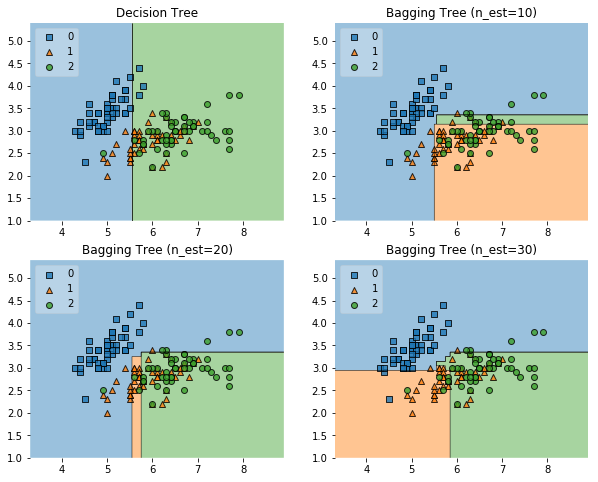

In [3]:
label = ['Decision Tree', 'Bagging Tree (n_est=10)', 'Bagging Tree (n_est=20)', 'Bagging Tree (n_est=30)']
clf_list = [clf, bagging10, bagging20, bagging30]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

### Boosting
The main difference between bagging and boosting is that boosting models are built sequentially, relying on the previous model to weight the data and help shape the next model. More weight is given to misclassified examples from earlier rounds while weight is taken away from correctly classified examples from earlier rounds. By building models that take into account the previous model's errors, we can get predictions with a decrease in bias. The predictions are combined in either a weighted majority vote (for classification) or through a weighted sum (for regression). Boosting algorithms don't use bootstrap sampling due to the fact that they rely on the previous model's weighting, and therefore training data, to function. 

One popular boosting model is AdaBoost (aka Adaptive Boosting). A simplified view of it's algorithm looks like:
```
Set initial weights to 1/N
For each model:
    Fit a model by minimizing the weighted error
    Compute the error
    Evaluate alpha (the weighting coefficient)
    Update the data weights
Make predictions by predicting on each model and aggregating their weighted results
```

Below is a more concrete example of a boosting algorithm in action.

In [4]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 10, 20, 30]
label = ['Decision Tree', 'AdaBoost (n_est=10)', 'AdaBoost (n_est=20)', 'AdaBoost (n_est=30)']

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.64 (+/- 0.14) [AdaBoost (n_est=10)]
Accuracy: 0.66 (+/- 0.12) [AdaBoost (n_est=20)]
Accuracy: 0.67 (+/- 0.13) [AdaBoost (n_est=30)]


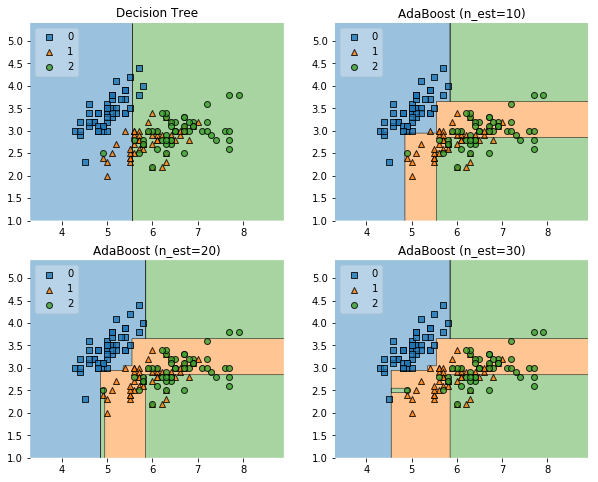

In [5]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)
    scores = cross_val_score(boosting, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

plt.show()

### Stacking
Usuallly when you're using bagging or boosting methods, your base estimator is the same throughout. These are called homogeneous ensembles. On the other hand, a stacking ensemble is often heterogeneous. Stacking is the process of combining multiple other classification or regression models via a meta-classifier or meta-regressor. The different base models are all trained on the complete training set and the meta-model is then trained using the outputs of the base models as features. While the other bagging and boosting models generally have default algorithms for combining their estimators, you have to explicitly state the algorithm you want a stacking model to use.

As the stacking method's main objective is prediction improvement, it is a commonly used technique for setting record performance on challenging datasets and winning Kaggle competitions. 

In [6]:
# Importing Data
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

# Instantiating Models
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=LogisticRegression())

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [Stacking Classifier]


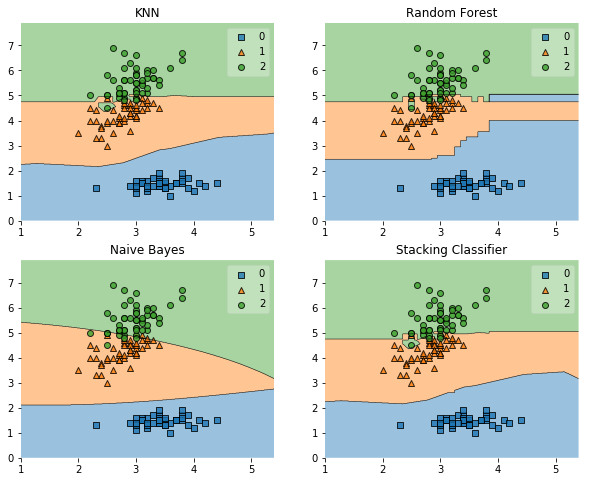

In [7]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()